In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import pingouin as pg
from scipy.stats import boxcox
from statsmodels.stats.anova import AnovaRM

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
data_file = DATA_PATH + "final_FLX_test.pkl"
proj_file = PROJECT_PATH + "FLX_Holdout_Projections_bxcx.csv"
mean_file = PROJECT_PATH + "{}_FLX_Holdout_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt
import pingouin as pg
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")
/hpc/home/mk423/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
df = pd.read_csv(proj_file)

In [4]:
mouse_encoder = OrdinalEncoder().fit(df.mouse.values.reshape(-1,1))
df_me = {
    "n1_scores":np.hstack([df[df.flx==1]["net 1 scores"],
                           df[df.flx==0]["net 1 scores"]]),
    
    "n2_scores":np.hstack([df[df.flx==1]["net 2 scores"],
                           df[df.flx==0]["net 2 scores"]]),
    
    "mouse":np.hstack([mouse_encoder.transform(df[df.flx==1]["mouse"].values.reshape(-1,1)).squeeze(),
                       mouse_encoder.transform(df[df.flx==0]["mouse"].values.reshape(-1,1)).squeeze()]).astype(int)+1,
    
    "flx":np.hstack([df[df.flx==1]["flx"],df[df.flx==0]["flx"]]).astype(int),
    
    "time":np.hstack([df[df.flx==1]["time"],df[df.flx==0]["time"]]),#MinMaxScaler().fit_transform(np.hstack([df[df.flx==1]["time"],df[df.flx==0]["time"]]).astype(float).reshape(-1,1)).squeeze(),
    
}

df_me = pd.DataFrame.from_dict(df_me)
#df_me.to_csv("/hpc/home/mk423/scaled_FLX_bxcx.csv",index=False)

In [10]:
stacks = []
time_scaler = MinMaxScaler()

for mouse in np.unique(df_me.mouse):
    for drug in np.unique(df_me.flx):
        mask = np.logical_and(df_me.mouse==mouse,df_me.flx==drug)
        
        #We want 60 minutes of Data
        for i in range(60):
            time_mask = np.logical_and(df_me.time > i*60, df_me.time <= (i+1)*60)
            temp_mask = np.logical_and(time_mask,mask).values
            
            n1_mean_score = np.nanmean(df_me[temp_mask==1].n1_scores.values)
            n2_mean_score = np.nanmean(df_me[temp_mask==1].n2_scores.values)
            
            stacks.append(np.array([n1_mean_score,n2_mean_score,mouse,drug,i]))
            
            
df_stats = pd.DataFrame(stacks,columns=["n1_scores","n2_scores","mouse","flx","minute"])

df_stats.minute = time_scaler.fit_transform(df_stats.minute.values.reshape(-1,1)).squeeze()
df_stats.n1_scores = boxcox(20*df_stats.n1_scores)[0]
df_stats.n2_scores = boxcox(20*df_stats.n2_scores)[0]

In [13]:
time_scaler.transform([[30]])

array([[0.50847458]])

In [23]:
from pingouin import rm_anova
rm_anova(dv="n1_scores",within=["minute","flx"],subject="mouse",data=df_stats)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,3.080009,59,295,0.052204,4.054338,7.825426e-16,0.014101,0.049029,0.068460
1,flx,4.293213,1,5,4.293213,9.165288,2.916734e-02,0.029167,0.067047,1.000000
2,minute * flx,0.888407,59,295,0.015058,1.136061,2.466370e-01,0.368043,0.014653,0.069951


In [22]:
rm_anova(dv="n2_scores",within=["minute","flx"],subject="mouse",data=df_stats)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,13.034927,59,295,0.220931,3.851086,9.982110e-15,0.015017,0.056540,0.072691
1,flx,20.771919,1,5,20.771919,5.755776,6.168788e-02,0.061688,0.087175,1.000000
2,minute * flx,4.293664,59,295,0.072774,1.356014,5.447795e-02,0.279306,0.019358,0.076220


### First 30 Minutes

In [25]:
rm_anova(dv="n1_scores",within=["minute","flx"],subject="mouse",data=df_stats[df_stats.minute < 0.50847458].copy())

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,1.343732,30,150,0.044791,3.232381,0.000001,0.045959,0.043012,0.109727
1,flx,2.763185,1,5,2.763185,14.578316,0.012396,0.012396,0.084604,1.000000
2,minute * flx,0.485816,30,150,0.016194,1.423756,0.087531,0.262239,0.015990,0.134106


In [29]:
rm_anova(dv="n2_scores",within=["minute","flx"],subject="mouse",data=df_stats[df_stats.minute < 0.50847458].copy())

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,3.251339,30,150,0.108378,2.180245,0.001177,0.105959,0.033266,0.136819
1,flx,9.868756,1,5,9.868756,7.866697,0.037781,0.037781,0.094569,1.000000
2,minute * flx,2.722885,30,150,0.090763,2.199698,0.001041,0.100393,0.028011,0.141867


### Adding more mice test

In [61]:
np.unique(df_stats.mouse)

array([1., 2., 3., 4., 5., 6.])

1


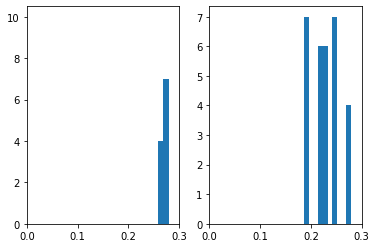

2


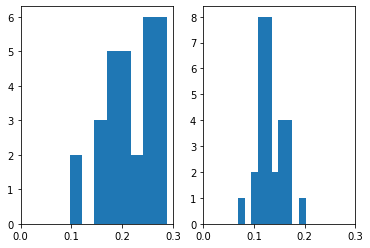

3


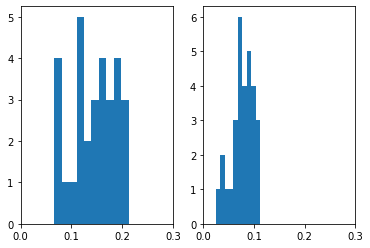

5


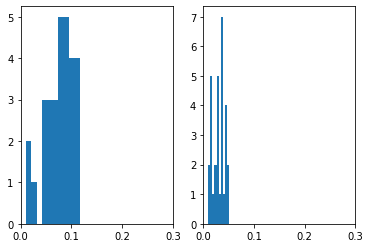

10


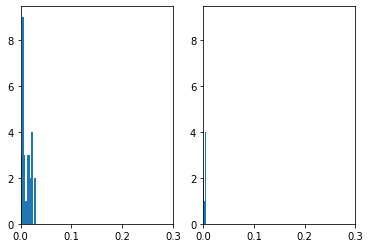

20


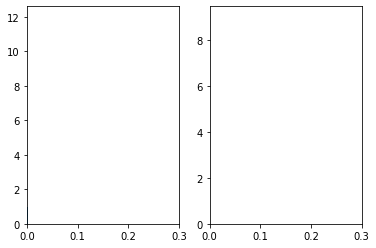

In [91]:
np.random.seed(42)
mice_options = np.unique(df_stats.mouse)
n1_ratios = []
n2_ratios = []
num_samps = 30

for i in [1,2,3,5,10,20]:
    print(i)
    num_n1_sig = 0
    num_n2_sig = 0
    n1_pvalues = []
    n2_pvalues = []
    for j in range(num_samps):
        base_df = df_stats.copy()
        choices = np.random.choice(mice_options,size=i)
        
        df_list = []
        for idx,mouse in enumerate(choices):
            temp = df_stats[df_stats.mouse==mouse].copy()
            temp.mouse = np.ones(temp.mouse.values.shape[0])*idx+len(mice_options)
            df_list.append(temp)
            
        df_list.append(base_df)
        aug_df = pd.concat(df_list)
        n1_result = rm_anova(dv="n1_scores",within=["minute","flx"],subject="mouse",data=aug_df)
        n2_result = rm_anova(dv="n2_scores",within=["minute","flx"],subject="mouse",data=aug_df)
        
        n1_pvalues.append(n1_result["p-GG-corr"].values[2])
        n2_pvalues.append(n2_result["p-GG-corr"].values[2])
        
        num_n1_sig += n1_result["p-GG-corr"].values[2] < 0.05
        num_n2_sig += n2_result["p-GG-corr"].values[2] < 0.05
        
        
        #print(aug_df.shape, choices, n1_pvalues[-1],n2_pvalues[-1])
        #print(choices)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.hist(n1_pvalues)
    plt.axvline(0.5,color="red",linestyle="--")
    plt.xlim([0,0.3])
    plt.subplot(1,2,2)
    plt.hist(n2_pvalues)
    plt.axvline(0.5,color="red",linestyle="--")
    plt.xlim([0,0.3])
    plt.show()
    n1_ratios.append(num_n1_sig / num_samps)
    n2_ratios.append(num_n2_sig / num_samps)


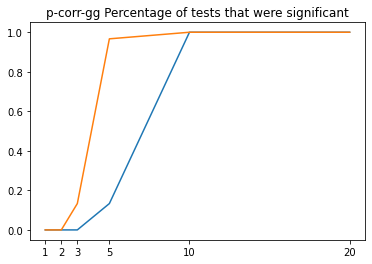

In [92]:
plt.plot([1,2,3,5,10,20],n1_ratios,label="n1")
plt.plot([1,2,3,5,10,20],n2_ratios,label="n2")
plt.xticks([1,2,3,5,10,20],[1,2,3,5,10,20])
plt.title("p-corr-gg Percentage of tests that were significant")
plt.show()

In [93]:
np.random.seed(42)
mice_options = np.unique(df_stats.mouse)
n1_ratios = []
n2_ratios = []
num_samps = 30

for i in [1,2,3,5,10,20]:
    print(i)
    num_n1_sig = 0
    num_n2_sig = 0
    n1_pvalues = []
    n2_pvalues = []
    for j in range(num_samps):
        base_df = df_stats.copy()
        choices = np.random.choice(mice_options,size=i)
        
        df_list = []
        for idx,mouse in enumerate(choices):
            temp = df_stats[df_stats.mouse==mouse].copy()
            temp.mouse = np.ones(temp.mouse.values.shape[0])*idx+len(mice_options)
            df_list.append(temp)
            
        df_list.append(base_df)
        aug_df = pd.concat(df_list)
        n1_result = rm_anova(dv="n1_scores",within=["minute","flx"],subject="mouse",data=aug_df)
        n2_result = rm_anova(dv="n2_scores",within=["minute","flx"],subject="mouse",data=aug_df)
        
        n1_pvalues.append(n1_result["p-unc"].values[2])
        n2_pvalues.append(n2_result["p-unc"].values[2])
        
        num_n1_sig += n1_result["p-unc"].values[2] < 0.05
        num_n2_sig += n2_result["p-unc"].values[2] < 0.05
        
        
        #print(aug_df.shape, choices, n1_pvalues[-1],n2_pvalues[-1])
        #print(choices)
    n1_ratios.append(num_n1_sig / num_samps)
    n2_ratios.append(num_n2_sig / num_samps)


1
2
3
5
10
20


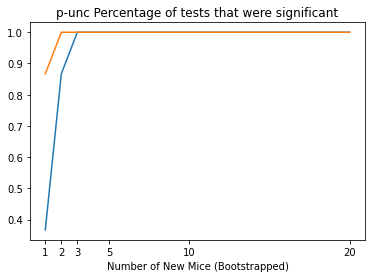

In [95]:
plt.plot([1,2,3,5,10,20],n1_ratios,label="n1")
plt.plot([1,2,3,5,10,20],n2_ratios,label="n2")
plt.xticks([1,2,3,5,10,20],[1,2,3,5,10,20])
plt.title("p-unc Percentage of tests that were significant")
plt.xlabel("Number of New Mice (Bootstrapped)")
plt.show()

### Mixed Effects Model

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM


re_formula = "0 + mouse"
md = MixedLM.from_formula("n1_scores ~ flx + time + flx*time",data=df_me,groups=df_me["mouse"],re_formula=re_formula)
result = md.fit()
print(result.summary())
print("flx:time",result.f_test("flx:time"))
print("flx",result.f_test("flx"))
print("time",result.f_test("time"))

/hpc/home/mk423/.local/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: n1_scores  
No. Observations: 44778   Method:             REML       
No. Groups:       6       Scale:              0.0005     
Min. group size:  6995    Log-Likelihood:     106956.8406
Max. group size:  8109    Converged:          Yes        
Mean group size:  7463.0                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.078    0.005  16.494 0.000  0.069  0.087
flx            0.007    0.000  16.497 0.000  0.006  0.008
time          -0.000    0.000 -10.941 0.000 -0.000 -0.000
flx:time      -0.000    0.000  -2.508 0.012 -0.000 -0.000
mouse Var      0.000    0.001                            

flx:time <F test: F=6.291600854957616, p=0.012134649947367756, df_denom=4.48e+04, df_num=1>
flx <F test: F=272.1503472497565, p=5.840504040

In [6]:

re_formula = "0 + mouse"

md = sm.MixedLM.from_formula("n2_scores ~ flx + time + flx*time",data=df_me,groups="mouse",re_formula=re_formula)
mdf = md.fit()
print(mdf.summary())

print("flx:time",mdf.f_test("flx:time"))
print("flx",mdf.f_test("flx"))
print("time",mdf.f_test("time"))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: n2_scores 
No. Observations: 44778   Method:             REML      
No. Groups:       6       Scale:              0.0019    
Min. group size:  6995    Log-Likelihood:     77246.0943
Max. group size:  8109    Converged:          Yes       
Mean group size:  7463.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.131    0.008  16.247 0.000  0.116  0.147
flx           0.008    0.001   9.841 0.000  0.006  0.010
time         -0.000    0.000 -17.064 0.000 -0.000 -0.000
flx:time      0.000    0.000   5.123 0.000  0.000  0.000
mouse Var     0.000    0.001                            

flx:time <F test: F=26.244064222585788, p=3.021242776217519e-07, df_denom=4.48e+04, df_num=1>
flx <F test: F=96.84739106373978, p=7.898722745442837e-23, d

/hpc/home/mk423/.local/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# FLX and Saline time ANOVAs

In [11]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('n1_scores ~ time',data=df_me[df_me.flx==1]).fit()
# Create ANOVA table
anova_table = sm.stats.anova_lm(model)

# Print the ANOVA table
print(anova_table)

               df       sum_sq    mean_sq           F        PR(>F)
time          1.0    24.656263  24.656263  129.191996  7.420493e-30
Residual  22605.0  4314.159090   0.190850         NaN           NaN


In [12]:
model = ols('n2_scores ~ time',data=df_me[df_me.flx==1]).fit()
# Create ANOVA table
anova_table = sm.stats.anova_lm(model)

# Print the ANOVA table
print(anova_table)

               df        sum_sq    mean_sq          F        PR(>F)
time          1.0     46.516975  46.516975  89.744809  2.967051e-21
Residual  22605.0  11716.735913   0.518325        NaN           NaN


In [13]:
model = ols('n1_scores ~ time',data=df_me[df_me.flx==0]).fit()
# Create ANOVA table
anova_table = sm.stats.anova_lm(model)

# Print the ANOVA table
print(anova_table)

               df       sum_sq    mean_sq           F        PR(>F)
time          1.0    24.577005  24.577005  141.256525  1.774734e-32
Residual  22169.0  3857.150157   0.173988         NaN           NaN


In [14]:
model = ols('n2_scores ~ time',data=df_me[df_me.flx==0]).fit()
# Create ANOVA table
anova_table = sm.stats.anova_lm(model)

# Print the ANOVA table
print(anova_table)

               df       sum_sq     mean_sq           F        PR(>F)
time          1.0   102.860734  102.860734  229.361195  1.488559e-51
Residual  22169.0  9942.046304    0.448466         NaN           NaN


# Basic 2 way anova results

In [ ]:
model_ols = ols('bxcx_net_1_scores ~ flx + time + flx:time',
            data = df).fit()
result = sm.stats.anova_lm(model_ols,type=2)
print(result)

               df     sum_sq   mean_sq           F         PR(>F)
flx           1.0   1.430382  1.430382  714.890099  2.934308e-156
time          1.0   0.539639  0.539639  269.705920   1.976932e-60
flx:time      1.0   0.000128  0.000128    0.064021   8.002509e-01
Residual  44774.0  89.585711  0.002001         NaN            NaN


In [ ]:
model_ols = ols('bxcx_net_2_scores ~ flx + time + flx:time',
            data = df).fit()
result = sm.stats.anova_lm(model_ols,type=2)
print(result)

               df      sum_sq   mean_sq           F         PR(>F)
flx           1.0    4.159003  4.159003  628.476779  9.595507e-138
time          1.0    1.955011  1.955011  295.426310   5.325842e-66
flx:time      1.0    0.088472  0.088472   13.369143   2.560910e-04
Residual  44774.0  296.296080  0.006618         NaN            NaN


/hpc/home/mk423/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
